# Pseudo potential method for Silicon

Thijenson  gets units wrong for lattice constant.

Used https://gist.github.com/wmedlar/12c13ded690b476739ab#file-pseudopotential-derived-band-structure-of-silicon-ipynb to fix errors and make code cleaner.

Other papers used:
https://journals.aps.org/prb/pdf/10.1103/PhysRevB.10.5095
https://danner.group/pseudopotential.htm

In [41]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [42]:
basisMatrix = np.array([[-1, 1, 1],[1, -1, 1],[1, 1, -1]])
a = 5.43*1.88973 
offset = np.ones(3)/8
nLim = 2
N = (2*nLim + 1)**3


In [43]:
Ks = []
for l,m,n in itertools.product(range(-nLim,nLim+1), repeat=3):
    Ks.append(np.array([l,m,n])) 

In [44]:
def V(KSquared):
    if KSquared == 3:
        return -0.1121
    elif KSquared == 8:
        return 0.0276
    elif KSquared == 11:
        return 0.0362
    return 0


def getE(k):
    H = np.empty([N, N])
    
    for r, c in itertools.product(range(N), repeat=2):
        if r == c:
            K = basisMatrix @ Ks[r]
            H[r,c] = 0.5*(2*np.pi*np.linalg.norm(k+K)/a)**2
        else:
            deltaK = basisMatrix @ (Ks[r] - Ks[c]) 
            VCoef = V(deltaK @ deltaK)
            if VCoef == 0:
                H[r,c] = 0
            else:
                H[r,c] = VCoef * np.cos(2*np.pi*deltaK @ offset)
    eigvals = np.linalg.eigvals(H)
    eigvals.sort()
    return eigvals[:8]

In [45]:
ks = [np.array([i/20,0,0]) for i in range(0,21)] #2pi/a units
Es = np.zeros([8,len(ks)])

for j,k in enumerate(ks):
    energyArr = getE(k)
    for i in range(8):
        Es[i,j] = energyArr[i]


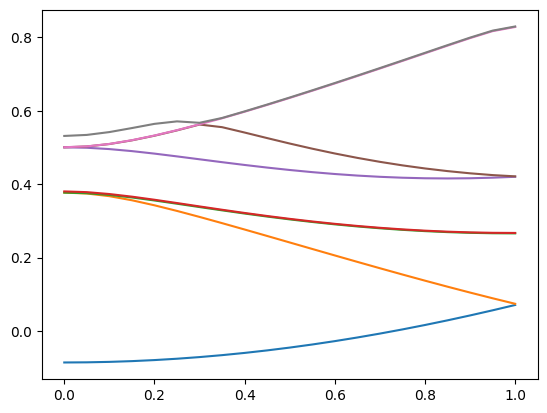

In [46]:
kx = list(map(lambda k: k[0],ks))


for i in range(8):
    plt.plot(kx,Es[i])




In [78]:
Ndiv2 = 2

KEAllowed = []
for l,m,n in itertools.product(range(-Ndiv2-2,Ndiv2 +3), repeat=3):
    K = 2*np.pi*basisMatrix@np.array([l/(2*Ndiv2),m/(2*Ndiv2),n/(2*Ndiv2)])/a
    for i,E in enumerate(getE(K)): 
        Ki = 2*np.pi*basisMatrix@np.array([l,m,n])/a
        KEAllowed.append(list(K + 2*Ki)+[E]) #need to use extended viewpoint

KEAllowed = sorted(KEAllowed,key=lambda l: l[3]) #better names and should find the fermi level


KAllowed = list(map(lambda KE: KE[:3],KEAllowed))
KOccupied = KAllowed[:16*Ndiv2**3]
print(KAllowed)

[[0.0, 0.0, 0.0], [1.377725825073929, 1.377725825073929, -1.377725825073929], [-1.377725825073929, -1.377725825073929, 1.377725825073929], [1.377725825073929, -1.377725825073929, -1.377725825073929], [1.377725825073929, -1.377725825073929, 1.377725825073929], [-1.377725825073929, 1.377725825073929, -1.377725825073929], [-1.377725825073929, 1.377725825073929, 1.377725825073929], [-1.377725825073929, -1.377725825073929, -1.377725825073929], [1.377725825073929, 1.377725825073929, 1.377725825073929], [0.0, 0.0, -2.755451650147858], [0.0, -2.755451650147858, 0.0], [0.0, 0.0, 2.755451650147858], [2.755451650147858, 0.0, 0.0], [-2.755451650147858, 0.0, 0.0], [0.0, 2.755451650147858, 0.0], [0.0, -2.755451650147858, 2.755451650147858], [-2.755451650147858, 0.0, 2.755451650147858], [2.755451650147858, 0.0, -2.755451650147858], [0.0, 2.755451650147858, -2.755451650147858], [2.755451650147858, -2.755451650147858, 0.0], [-2.755451650147858, 2.755451650147858, 0.0], [-2.755451650147858, -2.755451650

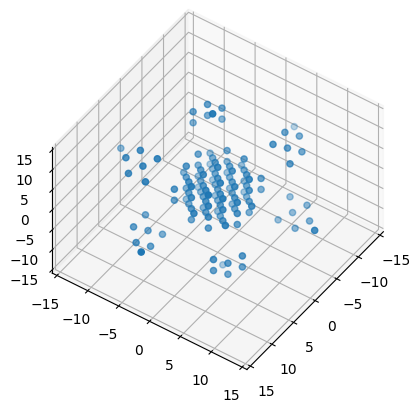

In [81]:
KOccupied = np.array(KOccupied)
ax = plt.axes(projection='3d')
ax.set_proj_type('ortho')
ax.scatter(KOccupied[:,0], KOccupied[:,1], KOccupied[:,2])
ax.view_init(45, 35)

